In [1]:
import sys 
import matplotlib.pyplot as plt
import numpy as np 
from numpy import sin, cos
from math import atan2
from pydot import graph_from_dot_data

sys.path.append("../")


from pydrake.common.value import Value
from pydrake.geometry import StartMeshcat, MeshcatVisualizer
from pydrake.systems.framework import DiagramBuilder, LeafSystem, BasicVector
from pydrake.multibody.math import SpatialForce
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph, ExternallyAppliedSpatialForce, ExternallyAppliedSpatialForceMultiplexer, AddMultibodyPlant
from pydrake.multibody.parsing import Parser
from pydrake.systems.analysis import Simulator
from pydrake.math import inv
from pydrake.systems.controllers import PidController

from pydrake.all import AbstractValue, LogVectorOutput,  JacobianWrtVariable


#from src.LauncherFunct.PlanarPRR_launcher import PlanarPRR_Controller
#from src.plant.PPR import PlanarPPR, ForwardKinPPR
#from src.mapping.PPR_theta import PlanarPPR_theta

#from src.mapping.PPR_extract_theta import ThetaExtractor

#from src.controller.CartesianContrellerEE import CartesianController

from manipulation.scenarios import AddMultibodyTriad


In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
from pydrake.systems.framework import Context, ContinuousState


class mapped_system(LeafSystem):

    def __init__(self, plant):
        
        LeafSystem.__init__(self)

        self.plant = plant
        self.plant_context = plant.CreateDefaultContext()
        self.M = np.zeros((3, 3))
        self.C = np.zeros(3)
        self.jac = np.zeros((2, 3)) # used as actuation matrix 
        self.Friction_term = np.zeros((3))

        self.Fc = 0.1
        self.Fv = 0.2
        
        self.jac_h = np.zeros((3, 3))
        self.jac_h_dot = np.zeros((3, 3))

        state_group_index = self.DeclareContinuousState(6) #theta

        self.DeclareStateOutputPort("state", state_group_index)

        self.DeclareVectorInputPort('Q', BasicVector(6))
        self.DeclareVectorInputPort("F", BasicVector(2))

    def eval_dyn(self, state_q):
        self.plant_context.SetDiscreteState(state_q)
        
        self._eval_jac()

        self._eval_C()
        self._eval_M()
        self._eval_friction_term(state_q)
        self._eval_jac_h()
        self._eval_jac_h_dot(state_q[-1])

    def _eval_friction_term(self, state_q):
        q_dot = np.array([state_q[3], state_q[2], state_q[1]])
        self.Friction_term = self.Fc*np.sign(q_dot) + self.Fv*q_dot

    def _eval_jac(self):
        j = self.plant.CalcJacobianPositionVector(self.plant_context,
                                        self.plant.GetBodyByName('l3').body_frame(), 
                                        np.array([0, 0, 0.25]),
                                        self.plant.world_frame(),
                                        self.plant.world_frame())
        self.jac = j[:2, :] # select only x,y component, angular
    
    def _eval_jac_h_dot(self, q3dot):
        # i'm able to find a cool way for automatic differentiation, so i decide to just calc analytically
        self.jac_h_dot[0, 2] = -self.jac_h[1, 2]*(q3dot)
        self.jac_h_dot[1, 2] = self.jac_h[0, 2]*(q3dot) 
 
    def _eval_jac_h(self):
        self.jac_h[:2, :] = self.jac
        self.jac_h[2, 2] = 1

    def _eval_M(self):
        self.M = self.plant.CalcMassMatrix(self.plant_context)

    def _eval_C(self):
        self.C = self.plant.CalcBiasTerm(self.plant_context)

    def DoCalcTimeDerivatives(self, context, next_state):

        state_theta = context.get_continuous_state_vector()
        theta_dot = np.array([state_theta[3], state_theta[4], state_theta[5]])

        state_q = self.GetInputPort('Q').Eval(context)
        F = self.GetInputPort("F").Eval(context)      
        self.eval_dyn(state_q)

        inv_jac_h = inv(self.jac_h)
        M_of_theta = inv_jac_h.T @ self.M @ inv_jac_h
        theta_dotdot = inv(M_of_theta)@(self.jac.T @ F) + (self.jac_h_dot @ inv_jac_h @ theta_dot) - self.C - self.Friction_term

        next_state.get_mutable_vector().SetFromVector(np.concatenate((theta_dot, theta_dotdot)))



In [4]:
def forward_kin(state):
    x = state[1] + 0.5*cos(state[2])
    y = state[0] + 0.5*sin(state[2])
    theta3 = state[2]
    return np.array([x, y, theta3, 0, 0, 0])

In [7]:
class MultibodyController(LeafSystem):
    
    def __init__(self, plant, Kp=0.2, Kd=0.5):
        LeafSystem.__init__(self)



        self.force_obj = ExternallyAppliedSpatialForce()
        self.force_obj.body_index = plant.GetBodyByName('l3').index()
        self.force_obj.p_BoBq_B = np.array([0, 0, 0.25]) # i belive that this is the translation vector to the EE

        self.DeclareVectorInputPort('theta_estimate', BasicVector(6))
        self.DeclareVectorInputPort("theta_desired", BasicVector(4))
        
        self.DeclareVectorOutputPort('F_2d', BasicVector(2), self.CalcForceControlVect)
        force_cls = Value[list[ExternallyAppliedSpatialForce]]
        self.DeclareAbstractOutputPort("F_abs", 
                                       lambda: force_cls(), 
                                       self.CalcSpatialForceControl)
        self.Kp = Kp
        self.Kd = Kd
        self.fx, self.fy = 0, 0
        

    def calc_out_force(self, state_estimate, state_req):

        theta = state_estimate[0], state_estimate[1]
        theta_dot = state_estimate[3], state_estimate[4]
        x_req, y_req = state_req

        self.fx = self.Kp*(x_req - theta[0]) - self.Kp*(theta_dot[0])
        self.fy = self.Kp*(y_req - theta[1]) - self.Kp*(theta_dot[1])


    def CalcForceControlVect(self, context, F_2d):
        state = self.GetInputPort('theta_estimate').Eval(context)
        x_req, y_req, _, _ = self.GetInputPort('theta_desired').Eval(context)
        self.calc_out_force(state, [x_req, y_req])
        F_2d.SetFromVector(np.array([self.fx, self.fy]))

    def CalcSpatialForceControl(self, context, F_abs):
        state = self.GetInputPort('theta_estimate').Eval(context)
        x_req, y_req, _, _ = self.GetInputPort('theta_desired').Eval(context)
        self.calc_out_force(state, [x_req, y_req])
        F = SpatialForce(tau=np.zeros(3), f=np.array([self.fx, self.fy, 0]))

        self.force_obj.F_Bq_W = F
        F_abs.set_value([self.force_obj])

In [11]:
meshcat.Delete()

builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-3)
Parser(plant, scene_graph).AddModels("../sdf_model/PPR_planar.sdf")
plant.Finalize()

mapping = builder.AddSystem(mapped_system(plant))
controller = builder.AddSystem(MultibodyController(plant))

BODY_NAMES = ['l1', 'l2', 'l3']
for body_name in BODY_NAMES:
    AddMultibodyTriad(plant.GetFrameByName(body_name), scene_graph)

visualizer = MeshcatVisualizer.AddToBuilder(
    builder,
    scene_graph.get_query_output_port(),
    meshcat
    )

builder.Connect(plant.GetOutputPort('state'), mapping.GetInputPort("Q"))
builder.Connect(controller.GetOutputPort('F_2d'), mapping.GetInputPort("F"))

builder.Connect(controller.GetOutputPort('F_abs'), plant.get_applied_spatial_force_input_port()) # F_2d -> Plant SpatialForce
builder.Connect(mapping.GetOutputPort('state'), controller.GetInputPort('theta_estimate'))

logger_mapping = LogVectorOutput(mapping.GetOutputPort("state"), builder)
logger_plant = LogVectorOutput(plant.get_state_output_port(), builder)

diagram = builder.Build()
context = diagram.CreateDefaultContext()


plant_context = plant.GetMyMutableContextFromRoot(context)
mapping_context = mapping.GetMyMutableContextFromRoot(context)
controller_context = controller.GetMyMutableContextFromRoot(context)

starting_condition = np.array([0, 0, 0, 0, 0, 0])

plant_context.SetDiscreteState(starting_condition)
mapping.plant_context.SetDiscreteState(starting_condition)

controller.GetInputPort('theta_desired').FixValue(controller_context, np.array([1.2, 0.2, 0, 0]))
mapping_context.SetContinuousState(forward_kin(starting_condition))

plant.GetInputPort('actuation').FixValue(plant_context, [0, 0, 0])


diagram.ForcedPublish(context)


In [9]:
"""
copy old value and publish it

funct used in addiction to pure-dyn-system

"""

theta = log_PPR.data()
for i in range(len(theta1)):
    q1 = theta[1][i] - 1*sin(theta[2][i])
    q2 = theta[0][i] - 1*cos(theta[2][i])
    state = np.array([q1, q2, theta[2][i], 0, 0, 0])
    plant_context.SetDiscreteState(state)
    diagram.ForcedPublish(context)

NameError: name 'log_PPR' is not defined

In [12]:
sim = Simulator(diagram, context)
sim.AdvanceTo(30)

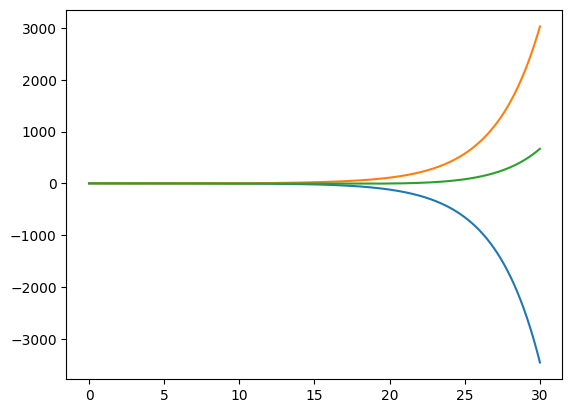

In [12]:
log_EE = logger_mapping.FindLog(context)
log_plant = logger_plant.FindLog(context)

time_vect = log_EE.sample_times()
plt.plot(time_vect, log_EE.data()[0], label='x_EE_mapped_Sys')
plt.plot(time_vect, log_EE.data()[1], label='y_EE_mapped_Sys')
plt.plot(time_vect, log_EE.data()[2], label='q3_EE_mapped_Sys')



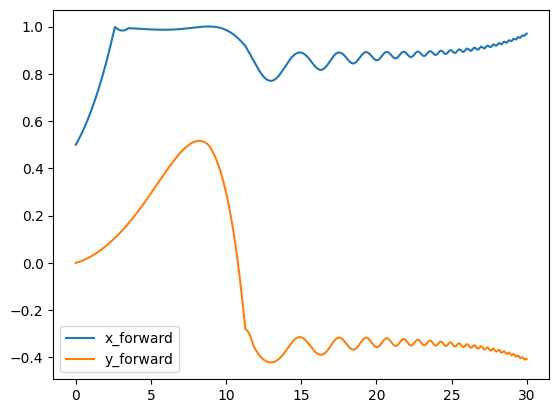

In [13]:

x_calc = []
y_calc = [] 

for i in range(len(log_plant.data()[0])):
    q1 = log_plant.data()[0][i]
    q2 = log_plant.data()[1][i]
    q3 = log_plant.data()[2][i]

    x_calc.append(q2+0.5*cos(q3))
    y_calc.append(q1+0.5*sin(q3))


plt.plot(time_vect, x_calc, label='x_forward')
plt.plot(time_vect, y_calc, label='y_forward')
plt.legend()

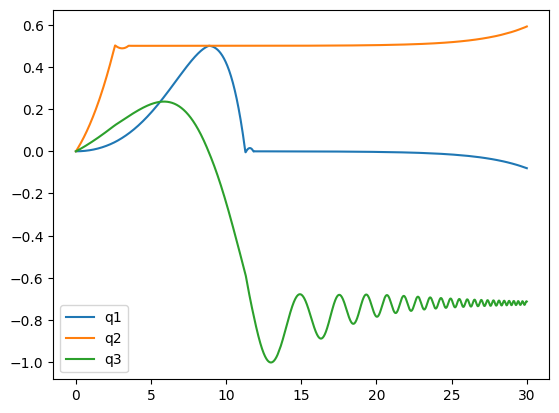

In [14]:


plt.plot(time_vect, log_plant.data()[0], label='q1')
plt.plot(time_vect, log_plant.data()[1], label='q2')
plt.plot(time_vect, log_plant.data()[2], label='q3')
plt.legend()